# Unit 5 - Financial Planning

In [156]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

##adding this to filter all the warnings from the Montecarlo simulation
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [35]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [25]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=USD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=USD"

In [27]:
# Fetch current BTC price
bitcoin_data = requests.get(btc_url).json()['data']['1']
bitcoin_price = bitcoin_data['quotes']['USD']['price']

# Fetch current ETH price
eth_data = requests.get(eth_url).json()['data']['1027']
eth_price = eth_data['quotes']['USD']['price']

# Compute current value of my crpto
my_btc_value = my_btc*bitcoin_price
my_eth_value = my_eth*eth_price

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")


The current value of your 1.2 BTC is $26204.40
The current value of your 5.3 ETH is $8068.56


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [30]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [40]:
# Set Alpaca API key and secret
API_KEY = os.getenv('API_KEY')
API_SECRET = os.getenv('API_SECRET')
BASE_URL= os.getenv('BASE_URL')

# Create the Alpaca API object
alpaca_client = tradeapi.REST(API_KEY, API_SECRET, BASE_URL)

In [123]:
# Format current date as ISO format
## if it is not yet 4pm, then we can only get the prices for the previous day. 
current_date = pd.Timestamp('2022-07-18', tz='America/New_York').isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
c_stock_data = alpaca_client.get_bars(tickers, timeframe, current_date).df
##creating a filter to get only the AGG data
agg_mask = c_stock_data['symbol']=='AGG'
agg_close_price = c_stock_data[agg_mask]['close']
## Creating a filter to get only the SPY data
spy_mask = c_stock_data['symbol']=='SPY'
spy_close_price = c_stock_data[spy_mask]['close']

# Reorganize the DataFrame
# Separate ticker data
##applying the agg filter
agg_df = c_stock_data[agg_mask]
## getting only the relevant columns
agg = agg_df.iloc[: , :5]

##applying the spy filter
spy_df = c_stock_data[spy_mask]
##getting only the relevant columns
spy = spy_df.iloc[:, :5]

# Concatenate the ticker DataFrames
## concatenating both dataframes side by side using the SPY and AGG keys
final_df = pd.concat([spy, agg], axis = 1, keys = ['SPY', 'AGG'])

# Preview DataFrame
final_df.head()


SPY                                      AGG  \
                             open    high     low   close    volume   open   
timestamp                                                                    
2022-07-18 04:00:00+00:00  388.27  389.09  380.66  381.95  62903915  102.0   

                                                            
                             high     low   close   volume  
timestamp                                                   
2022-07-18 04:00:00+00:00  102.03  101.72  101.92  4949050

In [127]:
# Pick AGG and SPY close prices
agg_close_price = agg_close_price[0]
spy_close_price = spy_close_price[0]

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $101.92
Current SPY closing price: $381.95


In [129]:
# Compute the current value of shares
my_spy_value = my_spy * spy_close_price
my_agg_value = my_agg * agg_close_price

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $19097.50
The current value of your 200 AGG shares is $20384.00


### Savings Health Analysis

In [136]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
total_crypto = my_btc_value + my_eth_value
share_value = my_spy_value+ my_agg_value

# Create savings DataFrame
df_savings = pd.DataFrame({'amount':[total_crypto, share_value]}, index = ['crypto', 'shares'])

# Display savings DataFrame
display(df_savings)

,amount
crypto,34272.961
shares,39481.500


<AxesSubplot:title={'center':'Composition of Personal Savings'}, ylabel='amount'>

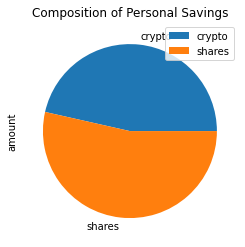

In [137]:
# Plot savings pie chart
df_savings.plot(kind='pie', y= 'amount', title = "Composition of Personal Savings")

In [138]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = total_crypto + share_value

# Validate saving health
if total_savings > emergency_fund: 
    print(" Congratulations! You have enough money in your emergency fund.")
elif total_savings== emergency_fund: 
    print("Congratulations! You have reached your financial goal")
else: 
    difference = emergency_fund - total_savings
    print(f"You are only {difference} dollars away from reaching the goal")

 Congratulations! You have enough money in your emergency fund.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [139]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2017-07-19', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2022-07-19', tz='America/New_York').isoformat()

In [148]:
# Get 5 years' worth of historical data for SPY and AGG
hist_df = alpaca_client.get_bars(tickers, timeframe, start_date, end_date).df

# Reorganize the DataFrame
# Separate ticker data
agg_mask = hist_df['symbol']=="AGG"
spy_mask = hist_df['symbol']=="SPY"


##filtering the data
agg_df = hist_df[agg_mask]
spy_df = hist_df[spy_mask]

##getting only the relevant columns
agg = agg_df.iloc[: , :5]
spy = spy_df.iloc[:, :5]

# Concatenate the ticker DataFrames
df_stock_data = pd.concat([agg,spy], axis = 1, keys = ['AGG', 'SPY'])

# Display sample data
df_stock_data.head()

AGG                                      SPY  \
                             open    high     low   close   volume    open   
timestamp                                                                    
2017-07-19 04:00:00+00:00  109.72  109.75  109.63  109.70  1577734  246.01   
2017-07-20 04:00:00+00:00  109.85  109.88  109.70  109.73  1802663  247.25   
2017-07-21 04:00:00+00:00  109.88  109.96  109.83  109.92  1532056  246.43   
2017-07-24 04:00:00+00:00  109.84  109.92  109.76  109.82  1946019  246.81   
2017-07-25 04:00:00+00:00  109.60  109.63  109.39  109.43  2601670  247.70   

                                                             
                             high     low   close    volume  
timestamp                                                    
2017-07-19 04:00:00+00:00  247.00  246.01  246.99  51034260  
2017-07-20 04:00:00+00:00  247.42  246.47  247.10  47135183  
2017-07-21 04:00:00+00:00  246.91  246.18  246.88  88343519  
2017-07-24 04:00:00+00:00  246.98  246.28  246.82  46622256  
2017-07-25 04:00:00+00:00  247.80  247.16  247.42  54915591

In [153]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
portfolio = df_stock_data
weights = [0.4,0.6]
simulation_no = 500
trading_days= 30*365

Monte_Carlo = MCSimulation(portfolio, weights, simulation_no, trading_days)


In [154]:
# Printing the simulation input data
portfolio.head()

AGG                                      SPY  \
                             open    high     low   close   volume    open   
timestamp                                                                    
2017-07-19 04:00:00+00:00  109.72  109.75  109.63  109.70  1577734  246.01   
2017-07-20 04:00:00+00:00  109.85  109.88  109.70  109.73  1802663  247.25   
2017-07-21 04:00:00+00:00  109.88  109.96  109.83  109.92  1532056  246.43   
2017-07-24 04:00:00+00:00  109.84  109.92  109.76  109.82  1946019  246.81   
2017-07-25 04:00:00+00:00  109.60  109.63  109.39  109.43  2601670  247.70   

                                                             
                             high     low   close    volume  
timestamp                                                    
2017-07-19 04:00:00+00:00  247.00  246.01  246.99  51034260  
2017-07-20 04:00:00+00:00  247.42  246.47  247.10  47135183  
2017-07-21 04:00:00+00:00  246.91  246.18  246.88  88343519  
2017-07-24 04:00:00+00:00  246.98  246.28  246.82  46622256  
2017-07-25 04:00:00+00:00  247.80  247.16  247.42  54915591

In [157]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
Monte_Carlo.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.010472,1.005484,1.006721,0.999998,0.999677,0.996881,1.015606,1.013580,1.001930,1.006980,...,0.986938,1.002085,0.994627,1.008436,0.997330,1.008085,1.009115,1.008052,1.011053,0.991114
2,1.007268,1.001191,1.000916,0.998899,1.007264,1.000113,1.017748,1.013952,1.006260,1.014223,...,0.991273,1.008026,0.996057,1.009447,1.000779,1.004004,1.006934,1.016744,1.006424,0.994325
3,1.004415,0.997281,1.015036,0.987882,1.009452,1.001246,1.011700,1.010257,1.013068,1.031352,...,0.997896,0.992995,0.995791,0.992968,0.990623,1.008409,1.014423,1.017867,1.006116,0.986248
4,1.009014,0.994533,1.010772,0.996930,1.004498,0.996398,1.013340,0.998191,1.009938,1.023806,...,0.996150,1.000286,0.992190,1.006556,0.985652,1.006779,1.032168,1.019942,1.007011,0.980254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10946,3.544807,4.058637,48.165175,17.801201,5.927442,18.905288,47.752188,26.187480,7.288055,7.962485,...,3.916860,15.844176,12.981800,1.506864,6.033430,19.912034,12.475170,11.549675,10.463750,11.999777
10947,3.511915,4.021679,48.268032,17.969340,5.956101,18.783698,48.578120,26.281795,7.296583,7.975820,...,3.912512,15.686933,12.961231,1.482489,6.059063,20.008273,12.436579,11.443127,10.419022,12.091317
10948,3.559746,4.076992,48.565439,17.935360,6.001223,18.825127,48.852708,26.237431,7.347421,7.927653,...,3.931636,15.590066,12.872354,1.492587,6.053455,20.051929,12.420600,11.500095,10.553049,12.217365
10949,3.541778,4.065399,48.615558,17.882798,6.061720,18.602729,48.819417,26.453434,7.369554,7.906329,...,3.908887,15.750904,12.916246,1.511900,6.094504,20.051069,12.487790,11.537477,10.536732,12.085765


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 10950 Trading Days.'}>

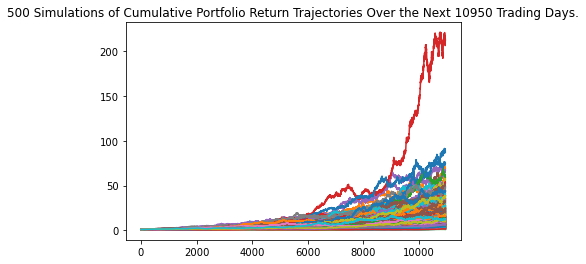

In [158]:
# Plot simulation outcomes
Monte_Carlo.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

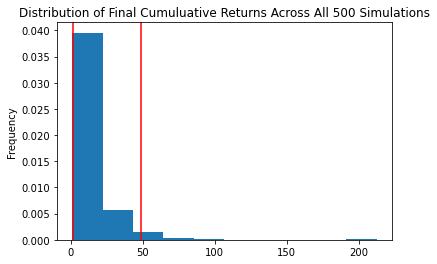

In [159]:
# Plot probability distribution and confidence intervals
Monte_Carlo.plot_distribution()

### Retirement Analysis

In [162]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_statistics = Monte_Carlo.summarize_cumulative_return()

# Print summary statistics
print(summary_statistics)

count           500.000000
mean             13.946115
std              15.174541
min               1.047475
25%               5.834571
50%               9.478235
75%              16.686730
max             212.357950
95% CI Lower      1.787286
95% CI Upper     49.148449
Name: 10950, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [163]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(summary_statistics[8]*initial_investment,2)
ci_upper = round(summary_statistics[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $35745.71 and $982968.98


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [164]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(summary_statistics[8]*initial_investment,2)
ci_upper = round(summary_statistics[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $53618.57 and $1474453.47


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [170]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
portfolio = df_stock_data
weights = [0.4,0.6]
simulation_no = 500
trading_days= 5*365

Monte_Carlo_5 = MCSimulation(portfolio, weights, simulation_no, trading_days)

In [171]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
Monte_Carlo_5.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.998934,1.006809,1.000494,1.006518,0.995292,0.991835,0.997720,1.021817,0.992889,0.995938,...,0.997489,0.996297,0.993213,0.989206,1.009132,1.002227,1.002233,1.007004,1.007358,0.993841
2,1.001271,1.005188,1.012253,0.998373,0.997575,0.977013,0.986452,1.021460,0.993439,1.006827,...,0.994224,0.994036,0.993216,1.001451,1.000187,1.002895,0.990618,1.007293,1.016604,0.993975
3,0.989863,1.009957,1.019634,1.011439,0.990922,0.971964,0.984078,1.013585,0.994494,1.014777,...,0.989655,0.981266,0.982890,1.006283,1.001887,1.000672,0.992057,1.012203,1.028392,0.984712
4,0.980452,1.013032,1.018464,1.004318,0.996378,0.979923,0.984190,1.006506,0.983387,1.017581,...,1.006660,0.978037,0.988125,1.003782,1.014329,1.007599,0.987306,1.010682,1.030487,0.987240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,0.930275,1.598814,0.815287,0.955697,2.097889,1.097775,2.048243,1.652459,1.119635,1.135614,...,1.939404,1.077943,0.856560,1.921243,2.652716,2.686716,1.766706,1.607638,1.524933,1.332027
1822,0.933646,1.596230,0.813342,0.952093,2.092961,1.090982,2.047002,1.673472,1.123967,1.130946,...,1.934424,1.070799,0.859730,1.913353,2.646161,2.687386,1.744570,1.625807,1.533340,1.339320
1823,0.942484,1.599068,0.809069,0.957610,2.079821,1.076110,2.055270,1.678232,1.121927,1.122151,...,1.934804,1.075816,0.858444,1.920213,2.655426,2.697759,1.752278,1.629999,1.557689,1.347832
1824,0.944750,1.590930,0.800711,0.952339,2.098722,1.093061,2.071046,1.662963,1.142113,1.124857,...,1.978387,1.085805,0.859315,1.920222,2.671454,2.673719,1.740605,1.607607,1.569714,1.366876


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1825 Trading Days.'}>

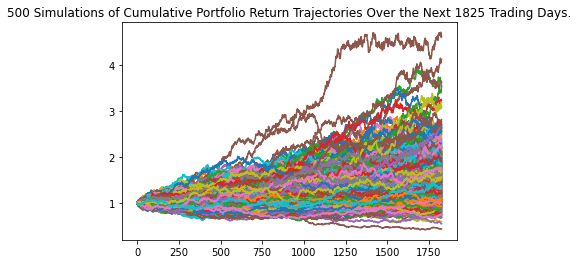

In [172]:
# Plot simulation outcomes
Monte_Carlo_5.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

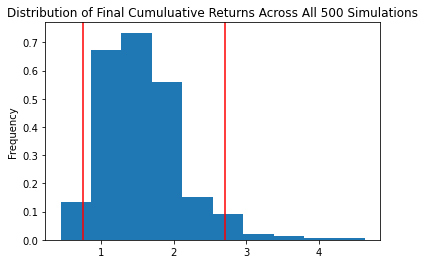

In [173]:
# Plot probability distribution and confidence intervals
Monte_Carlo_5.plot_distribution()

In [174]:
# Fetch summary statistics from the Monte Carlo simulation results
stats = Monte_Carlo_5.summarize_cumulative_return()

# Print summary statistics
print(stats)

count           500.000000
mean              1.550186
std               0.539166
min               0.437194
25%               1.173475
50%               1.477692
75%               1.852957
max               4.631514
95% CI Lower      0.752345
95% CI Upper      2.709299
Name: 1825, dtype: float64


In [176]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(stats[8]*initial_investment,2)
ci_upper_five = round(stats[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years will end within in the range of $45140.7 and $162557.96


### Ten Years Retirement Option

In [178]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
portfolio = df_stock_data
weights = [0.4,0.6]
simulation_no = 500
trading_days= 10*365

Monte_Carlo_ten = MCSimulation(portfolio, weights, simulation_no, trading_days)

In [179]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
Monte_Carlo_ten.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.005279,0.992998,0.999365,1.014279,0.992004,1.000114,0.987855,0.997710,1.003694,0.998852,...,0.998228,1.016350,1.001343,1.008149,0.996901,0.999186,1.006511,1.006387,0.991792,1.011463
2,1.016519,0.976191,1.007322,1.010957,0.986788,0.993600,1.001509,1.005200,1.013924,1.004473,...,1.004399,1.020017,0.985871,1.010097,0.997892,0.997314,1.004718,0.997057,0.981437,1.001120
3,1.015703,0.975927,0.998034,1.004544,0.991731,0.996964,1.019395,1.005926,1.020053,1.015084,...,1.001062,1.019851,0.987839,1.015460,1.000457,0.986133,1.015375,0.996743,0.984996,0.998410
4,1.015754,0.978979,0.999334,1.011968,0.993890,0.991576,1.006610,1.004782,1.018324,1.011226,...,1.006488,1.013625,0.972239,1.022373,0.999558,0.984062,1.011687,0.986667,0.982695,0.993413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3646,3.523582,2.930059,1.157483,3.351120,1.517520,3.160113,3.444035,0.638128,2.851259,1.032352,...,2.206245,2.296009,2.589829,1.151177,3.424771,4.781419,1.596227,1.996539,1.533820,2.315151
3647,3.509449,2.873546,1.153560,3.353957,1.525865,3.217782,3.436947,0.640393,2.858617,1.030073,...,2.241893,2.264849,2.585869,1.135452,3.418278,4.774845,1.604252,1.961931,1.525678,2.336200
3648,3.504287,2.869856,1.157697,3.320586,1.497925,3.220900,3.438260,0.634882,2.848968,1.020973,...,2.259802,2.296094,2.596545,1.145222,3.424260,4.806021,1.603749,2.006014,1.534059,2.312777
3649,3.509271,2.887960,1.145397,3.316292,1.495856,3.194212,3.437897,0.641799,2.858501,1.020949,...,2.266530,2.307180,2.554641,1.144861,3.407077,4.785680,1.617193,2.044160,1.532957,2.298316


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 3650 Trading Days.'}>

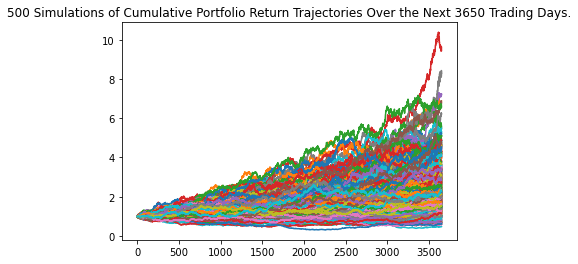

In [180]:
# Plot simulation outcomes
Monte_Carlo_ten.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

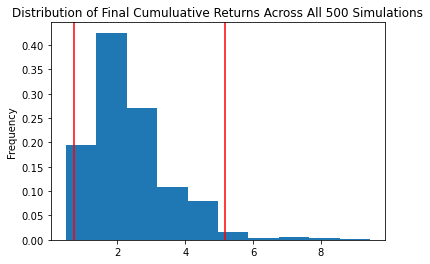

In [181]:
# Plot probability distribution and confidence intervals
Monte_Carlo_ten.plot_distribution()

In [182]:
# Fetch summary statistics from the Monte Carlo simulation results
stats_ten = Monte_Carlo_ten.summarize_cumulative_return()

# Print summary statistics
print(stats_ten)

count           500.000000
mean              2.391491
std               1.228272
min               0.476284
25%               1.551714
50%               2.125829
75%               2.925210
max               9.453360
95% CI Lower      0.731211
95% CI Upper      5.162326
Name: 3650, dtype: float64


In [184]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(stats_ten[8]*initial_investment,2)
ci_upper_ten = round(stats_ten[9]*initial_investment,2)


# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within in the range of $43872.65 and $309739.56
